In [783]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImagePyramid(nn.Module):
    def __init__(self, kernel_size=5) -> None:
        super(ImagePyramid, self).__init__()
        self.kernel = self._gauss_kernel(kernel_size=kernel_size, channels=3)
        self.single_kernel = self._gauss_kernel(kernel_size=kernel_size, channels=1)
    
    def _gauss_kernel(self, kernel_size=5, channels=3):
        kernel = torch.tensor([[1., 4., 6., 4., 1],
                               [4., 16., 24., 16., 4.],
                               [6., 24., 36., 24., 6.],
                               [4., 16., 24., 16., 4.],
                               [1., 4., 6., 4., 1.]])
        kernel /= 256.
        kernel = kernel.repeat(channels, 1, 1, 1)
        return kernel
    
    def _downsample(self, x):
        return x[:, :, ::2, ::2]
    
    def _upsample(self, x):
        cc = torch.cat([x, torch.zeros(x.shape[0], x.shape[1], x.shape[2], x.shape[3], device=x.device)], dim=3)
        cc = cc.view(x.shape[0], x.shape[1], x.shape[2]*2, x.shape[3])
        cc = cc.permute(0,1,3,2)
        cc = torch.cat([cc, torch.zeros(x.shape[0], x.shape[1], x.shape[3], x.shape[2]*2, device=x.device)], dim=3)
        cc = cc.view(x.shape[0], x.shape[1], x.shape[3]*2, x.shape[2]*2)
        x_up = cc.permute(0,1,3,2)
        return self._conv_gauss(x_up, 4 * self.kernel)
    
    def _conv_gauss(self, img, kernel):
        return F.conv2d(F.pad(img, (2, 2, 2, 2), mode='reflect'), kernel, groups=img.shape[1])
    
    def forward(self, img, gauss_levels=5, mode='all'):
        '''
        guass_pyramid_size: 512(input image), 256, 128, 64
        laplacian_pyramid_size: 512, 256, 128, 64(minist image)
        '''
        if mode == 'gauss':
            gauss_pyramid = []
            gauss_pyramid.append(img)
            for _ in range(gauss_levels - 1):
                filtered = self._conv_gauss(img, self.kernel if img.shape[1] == 3 else self.single_kernel)
                down = self._downsample(filtered)
                gauss_pyramid.append(down)
                img = down
            return gauss_pyramid
        elif mode == 'laplacian':
            lap_pyramid = []
            for _ in range(gauss_levels - 1):
                filtered = self._conv_gauss(img, self.kernel if img.shape[1] == 3 else self.single_kernel)
                down = self._downsample(filtered)
                up = self._upsample(down)
                diff = img - up
                lap_pyramid.append(diff)
                img = down
            lap_pyramid.append(img)
            return lap_pyramid
        elif mode == 'all':
            gauss_pyramid = []
            lap_pyramid = []
            gauss_pyramid.append(img)
            for _ in range(gauss_levels - 1):
                filtered = self._conv_gauss(img, self.kernel if img.shape[1] == 3 else self.single_kernel)
                down = self._downsample(filtered)
                up = self._upsample(down)
                diff = img - up
                gauss_pyramid.append(down)
                lap_pyramid.append(diff)
                img = down
            lap_pyramid.append(img)
            return gauss_pyramid, lap_pyramid
        else:
            assert False, 'mode must be gauss, laplacian or all'

In [784]:
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image

image = '1'

high = ToTensor()(Image.open('fusion/%s_high.png' % image)).unsqueeze(0)
middle = ToTensor()(Image.open('fusion/%s_middle.png' % image)).unsqueeze(0)
low = ToTensor()(Image.open('fusion/%s_low.png' % image)).unsqueeze(0)

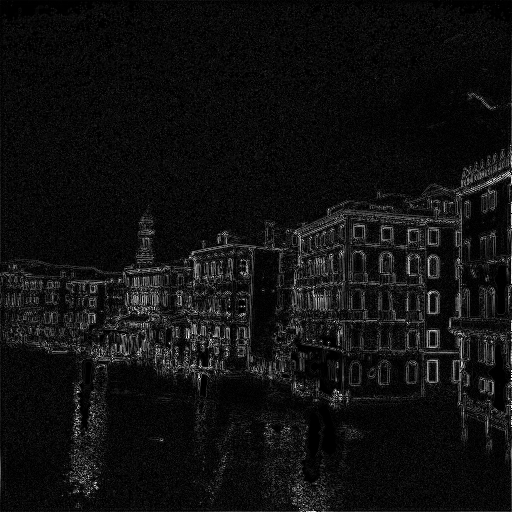

In [785]:
def rgb2gray(img):
    return 0.3 * img[:, 0:1, :, :] + 0.59 * img[:, 1:2, :, :] + 0.11 * img[:, 2:3, :, :]

kernel = torch.tensor([[0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]], dtype=torch.float, requires_grad=False).view(1, 1, 3, 3)

enhance_c_weight = torch.abs(F.conv2d(rgb2gray(enhance), kernel, padding=1))
middle_c_weight = torch.abs(F.conv2d(rgb2gray(middle), kernel, padding=1))
suppress_c_weight = torch.abs(F.conv2d(rgb2gray(suppress), kernel, padding=1))

ToPILImage()(enhance_c_weight[0])

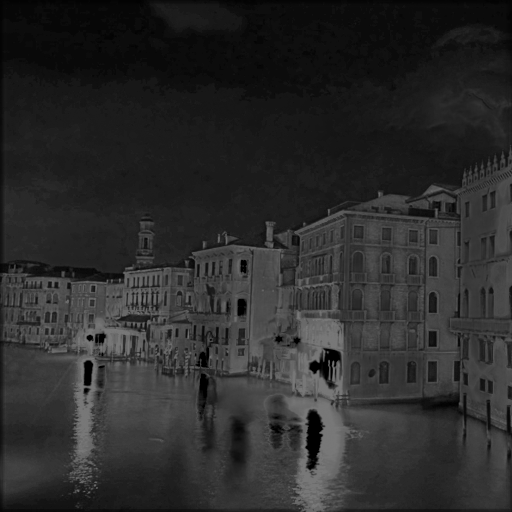

In [786]:
def gen_s(img):
    tmp = torch.mean(img, dim=1, keepdim=True).repeat(1, 3, 1, 1)
    img = img - tmp
    img = img ** 2
    img = torch.sqrt(torch.sum(img, dim=1, keepdim=True) / 3)
    return img

enhance_s_weight = gen_s(enhance)
middle_s_weight = gen_s(middle)
suppress_s_weight = gen_s(suppress)

ToPILImage()(enhance_s_weight[0])

tensor(0)


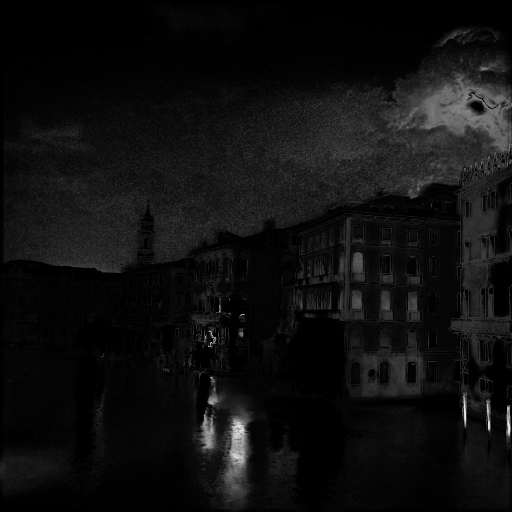

In [787]:
def gen_w(img):
    r = torch.exp(-((img[:,0:1,:,:] - 0.5) ** 2) / (2 * 0.2 * 0.2)) 
    g = torch.exp(-((img[:,1:2,:,:] - 0.5) ** 2) / (2 * 0.2 * 0.2))
    b = torch.exp(-((img[:,2:3,:,:] - 0.5) ** 2) / (2 * 0.2 * 0.2))
    return r * g * b

enhance_w_weight = gen_w(enhance)
middle_w_weight = gen_w(middle)
suppress_w_weight = gen_w(suppress)

print(torch.isnan(enhance_w_weight[0]).sum())
ToPILImage()(enhance_w_weight[0])

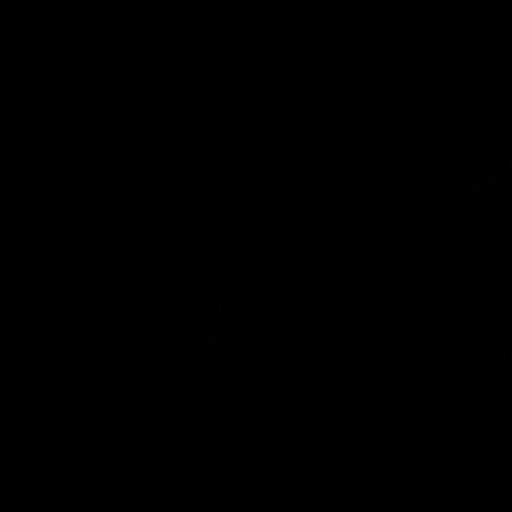

In [788]:
enhance_weight = enhance_c_weight * enhance_s_weight * enhance_w_weight
middle_weight = middle_c_weight * middle_s_weight * middle_w_weight
suppress_weight = suppress_c_weight * suppress_s_weight * suppress_w_weight

ToPILImage()(enhance_weight[0])

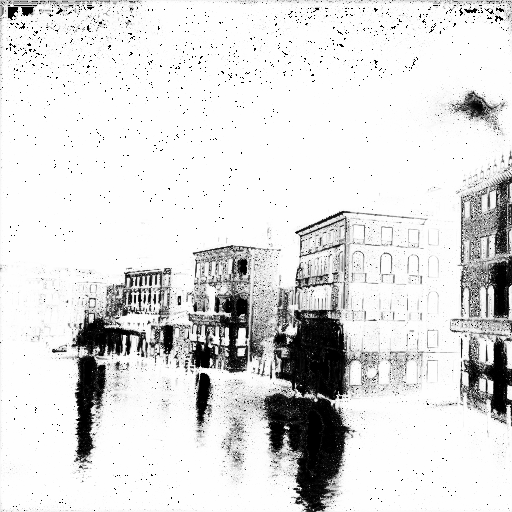

In [789]:
tmp = enhance_weight + middle_weight + suppress_weight + 1e-8
enhance_weight_linear = enhance_weight / tmp
middle_weight_linear = middle_weight / tmp
suppress_weight_linear = suppress_weight / tmp

ToPILImage()(enhance_weight_linear[0])

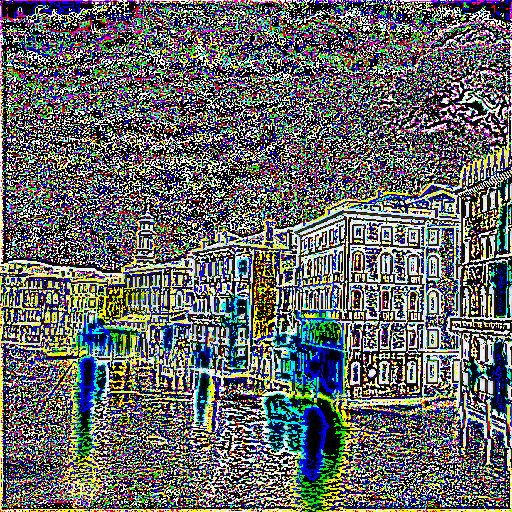

In [790]:
Pyramid = ImagePyramid(kernel_size=5)

enhance_lap = Pyramid(enhance, mode='laplacian')
middle_lap = Pyramid(middle, mode='laplacian')
suppress_lap = Pyramid(suppress, mode='laplacian')

ToPILImage()(enhance_lap[0][0])

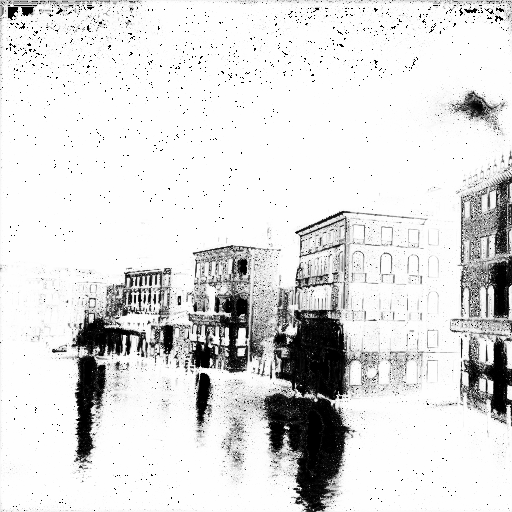

In [791]:
import torchvision

Pyramid = ImagePyramid(kernel_size=5)

enhance_w_gauss = Pyramid(enhance_weight_linear, mode='gauss')
middle_w_gauss = Pyramid(middle_weight_linear, mode='gauss')
suppress_w_gauss = Pyramid(suppress_weight_linear, mode='gauss')

ToPILImage()(enhance_w_gauss[0][0])

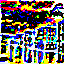

In [792]:
fusion_lap = [None] * 5

for i in range(5):
    # ToPILImage()(enhance_lap[i][0]).save('./enh_lap_{}.png'.format(i))
    # ToPILImage()(middle_lap[i][0]).save('./mid_lap_{}.png'.format(i))
    # ToPILImage()(suppress_lap[i][0]).save('./sup_lap_{}.png'.format(i))

    fusion_lap[i] = enhance_lap[i] * enhance_w_gauss[i].repeat(1, 3, 1, 1) + \
                    middle_lap[i] * middle_w_gauss[i].repeat(1, 3, 1, 1) + \
                    suppress_lap[i] * suppress_w_gauss[i].repeat(1, 3, 1, 1)

l1 = fusion_lap[0]
l2 = fusion_lap[1]
l3 = fusion_lap[2]
l4 = fusion_lap[3]
l5 = fusion_lap[4]

ToPILImage()(l4[0])

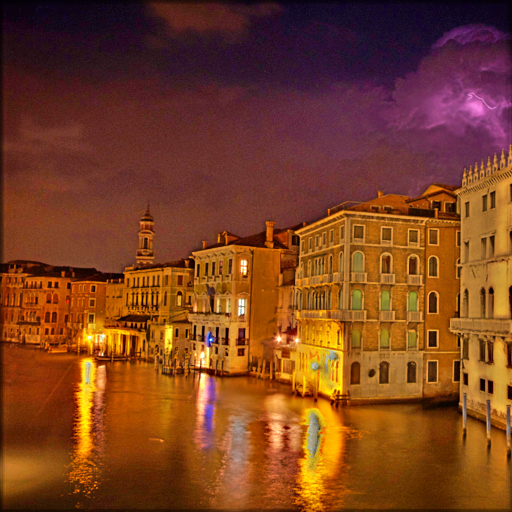

In [793]:
def _gauss_kernel(kernel_size=5, channels=3):
        kernel = torch.tensor([[1., 4., 6., 4., 1],
                               [4., 16., 24., 16., 4.],
                               [6., 24., 36., 24., 6.],
                               [4., 16., 24., 16., 4.],
                               [1., 4., 6., 4., 1.]])
        kernel /= 256.
        kernel = kernel.repeat(channels, 1, 1, 1)
        return kernel
    
def _downsample(x):
        return x[:, :, ::2, ::2]

def _conv_gauss(img, kernel):
        return F.conv2d(F.pad(img, (2, 2, 2, 2), mode='reflect'), kernel, groups=img.shape[1])

def _upsample(x):
        cc = torch.cat([x, torch.zeros(x.shape[0], x.shape[1], x.shape[2], x.shape[3], device=x.device)], dim=3)
        cc = cc.view(x.shape[0], x.shape[1], x.shape[2]*2, x.shape[3])
        cc = cc.permute(0,1,3,2)
        cc = torch.cat([cc, torch.zeros(x.shape[0], x.shape[1], x.shape[3], x.shape[2]*2, device=x.device)], dim=3)
        cc = cc.view(x.shape[0], x.shape[1], x.shape[3]*2, x.shape[2]*2)
        x_up = cc.permute(0,1,3,2)
        return _conv_gauss(x_up, 4 * _gauss_kernel())

image = (_upsample(_upsample(_upsample(_upsample(l5) + l4) + l3) + l2) + l1)[0]
ToPILImage()(torch.clip(image, 0, 1))